In [4]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt 

In [2]:
import requests

import torch

from PIL import Image

from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline

from transformers import AutoImageProcessor, UperNetForSemanticSegmentation
from PIL import Image
import numpy as np
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image

from diffusers import StableDiffusionUpscalePipeline



A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [51]:
## define a new class:

class Point():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def dist(self, p):
        return np.sqrt((self.x - p.x)**2 + (self.y - p.y)**2 + (self.z - p.z)**2)

    def __repr__(self):
        return f'({self.x}, {self.y}, {self.z})'

    def __sub__(self, p):
        return Point(self.x - p.x, self.y - p.y, self.z - p.z)

    def __mul__(self, p):
        return self.x * p.x + self.y * p.y + self.z * p.z
    
    def normalize(self):
        mnorm =  self.norm()
        if mnorm == 0.0:
            return Point(0.0, 0.0, 0.0)
        return Point(self.x/mnorm, self.y/mnorm, self.z/mnorm)

    def norm(self):
        norm = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        return norm
    
    def angle2d(self, direction):

        p_xy = Point(self.x, self.y, 0)


        ##theta = np.arccos(self.z / self.norm())
        ##phi = np.arctan2(self.z,np.sqrt(self.x**2 + self.y**2)) - np.arctan(direction.z/np.sqrt(direction.x**2 + direction.y**2))

        theta = np.arctan2(self.x,self.y) - np.arctan2(direction.x,direction.y)
        phi = np.arccos(self.z / self.norm()) - np.arccos(direction.z)
        return theta, phi

    def get_2d_coords(self, pov, direction, vision_angle, resolution_x, resolution_y, verbose):
        eps = 1e-6
        v = self - pov
        theta, phi = v.angle2d(direction)

        vision_angle = np.tan(vision_angle)
        phi = np.tan(phi)/ (np.abs(np.cos(theta)))
        theta = np.tan(theta)
        
        # vision_angle = np.clip(vision_angle, -np.pi, np.pi)
        # theta = np.clip(theta, -np.pi/2, np.pi/2)
        # phi = np.clip(phi, -np.pi/2, np.pi/2) 

        x = int((resolution_x//2) * (theta / vision_angle)) + resolution_x//2
        y = int((resolution_y//2) * (phi / vision_angle)) + resolution_y//2

        if verbose:
            print(v)
            print((theta / vision_angle,phi / vision_angle))
            print((x,y))
        return x, y

class Quad():
    counter = 1


    def __init__(self, p1, p2, p3, p4 , color = 'red', desc = 'plain', boxid = None):
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        self.p4 = p4
        self.center = Point((p1.x + p2.x + p3.x + p4.x)/4, (p1.y + p2.y + p3.y + p4.y)/4, (p1.z + p2.z + p3.z + p4.z)/4)
        self.id = Quad.counter
        self.color = color
        self.desc = desc
        self.boxid = boxid
        
        Quad.counter += 1

            
    def __repr__(self):
        return f'Quad({self.p1}, {self.p2}, {self.p3}, {self.p4})'

    def mindist(self,p):
        d1 = p.dist(self.p1)
        d2 = p.dist(self.p2)
        d3 = p.dist(self.p3)
        d4 = p.dist(self.p4)
        dc = p.dist(self.center)
        return np.min([d1,d2,d3,d4])
    
    def draw_quad(self, image, mapping, pov, direction, vision_angle, intensity, verbose, forcecolor):
        resolution_x = image.shape[0]
        resolution_y = image.shape[1]

        ## get the 2d coordinates of the 4 points
        p1 = self.p1.get_2d_coords(pov, direction, vision_angle, resolution_x, resolution_y, verbose)
        p2 = self.p2.get_2d_coords(pov, direction, vision_angle, resolution_x, resolution_y, verbose)
        p3 = self.p3.get_2d_coords(pov, direction, vision_angle, resolution_x, resolution_y, verbose)
        p4 = self.p4.get_2d_coords(pov, direction, vision_angle, resolution_x, resolution_y, verbose)

        
        if forcecolor is None:
            color = self.color
        else:
            color = forcecolor
            
        ## draw the quad

        
        pp = np.array([p1, p2, p3, p4])
                
        image = cv2.drawContours(image, [pp], 0, color, -1, cv2.LINE_AA)
        
        if verbose:
            plt.imshow(image)
            plt.show()
        # image = cv2.line(image, p1, p2, (0,0,0), 1)
        # image = cv2.line(image, p2, p3, (0,0,0), 1)
        # image = cv2.line(image, p3, p4, (0,0,0), 1)
        # image = cv2.line(image, p4, p1, (0,0,0), 1)
        
        
        mapping = cv2.drawContours(mapping, [pp], 0, (self.id,0,0), -1, cv2.LINE_AA)
        
        return image, mapping

class Box():
    
    counter = 1

    
    def __init__(self, p, w, h, d, color = 'red', desc = 'box'):
        self.x = p.x
        self.y = p.y
        self.z = p.z
        self.p = Point(self.x + w/2, self.y + h/2, self.z+h/2)
        self.w = w 
        self.h = h
        self.d = d
        self.color = color
        self.desc = desc
        self.id = Box.counter

        self.p000, self.p100, self.p110, self.p010, self.p001, self.p101, self.p111, self.p011 = self.get_points()
        self.quads = self.get_quads()

        Box.counter += 1
        
    def get_points(self):
        points = [  Point(self.x, self.y, self.z),
                    Point(self.x + self.w, self.y, self.z),
                    Point(self.x + self.w, self.y + self.h, self.z),
                    Point(self.x, self.y + self.h, self.z),
                    Point(self.x, self.y, self.z + self.d),
                    Point(self.x + self.w, self.y, self.z + self.d),
                    Point(self.x + self.w, self.y + self.h, self.z + self.d),
                    Point(self.x, self.y + self.h, self.z + self.d)
                 ]
        return points

    def get_quads(self):
        quad_x0 = Quad(self.p000, self.p100, self.p110, self.p010, self.color, self.desc, self.id) ## x= 0
        quad_y0 = Quad(self.p000, self.p100, self.p101, self.p001, self.color, self.desc, self.id) ## y= 0
        quad_z0 = Quad(self.p000, self.p010, self.p110, self.p100, self.color, self.desc, self.id) ## z= 0
        quad_x1 = Quad(self.p100, self.p110, self.p111, self.p101, self.color, self.desc, self.id) ## x= 1
        quad_y1 = Quad(self.p010, self.p110, self.p111, self.p011, self.color, self.desc, self.id) ## y= 1
        quad_z1 = Quad(self.p001, self.p101, self.p111, self.p011, self.color, self.desc, self.id) ## z= 1

        return [quad_x0, quad_y0, quad_z0, quad_x1, quad_y1, quad_z1]


        

class Sketch3d():    
    def __init__(self):

        ## sortable list
        
        self.boxes = []


    def add_box(self, box):
        self.boxes.append(box)



    def get_quads(self, pov, direction):        
        quads = []
        for box in self.boxes:
            quads += box.quads



        ##quads = [quad for quad in quads if (quad.center- pov) * direction > 0]

        sort_quad = sorted(quads, key=lambda quad: pov.dist(quad.center), reverse=True)



        return sort_quad



class Scene():
    def __init__(self, sketch3d, pov, direction , vision_angle = 30, resolution = (1024,1024), intensity = 0.7, margin = 1, verbose = False, skies = True):

        
        
        vision_angle = np.pi*vision_angle/180
        direction = direction.normalize()

        image = np.ones((resolution[0]*margin, resolution[1]*margin,3), dtype = np.uint8 )*255
        
        mapping = np.zeros((resolution[0]*margin, resolution[1]*margin,3), dtype = np.uint8)

        quads = sketch3d.get_quads(pov, direction)

        
        color = None
        for quad in quads:
            image, mapping = quad.draw_quad(image, mapping, pov, direction, vision_angle*margin, intensity = intensity, verbose = verbose, forcecolor = color)
        
        
        start = (margin-1)/2
        stop = (margin+1)/2
        if not margin == 1:
            image =   image[int(resolution[0]*start):int(resolution[0]*stop), int(resolution[1]*start):int(resolution[1]*stop)]
            mapping = mapping[int(resolution[0]*start):int(resolution[0]*stop), int(resolution[1]*start):int(resolution[1]*stop)]
        
        self.image = image
        plt.imshow(image)

        
    def get_img(self):
        return self.image

In [52]:
def color_dist(a,b):
    return np.sqrt( (a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2)

def random_color(r=None,g=None,b=None):
    r = r if r is not None else 255*np.random.uniform()
    g = g if g is not None else 255*np.random.uniform()
    b = b if b is not None else 255*np.random.uniform()
        
#     while color_dist((r,g,b),(200,200,255))< (110):
#         r = 255*np.random.uniform()
#         g = 255*np.random.uniform()
#         b = 255*np.random.uniform()
        
        
    return  (r,g,b)

In [58]:
skretch = Sketch3d()

skretch.add_box(Box(Point(60,90,0), 15, 15, 30, color = random_color(None,None,None)))
skretch.add_box(Box(Point(40,90,0), 15, 15, 30, color = random_color(None,None,None)))
skretch.add_box(Box(Point(20,90,0), 15, 15, 30, color = random_color(None,None,None)))
skretch.add_box(Box(Point(0,90,0), 15, 15, 30, color = random_color(None,None,None)))


skretch.add_box(Box(Point(60,130,0), 15, 15, 30, color = random_color(None,None,None)))
skretch.add_box(Box(Point(40,130,0), 15, 15, 30, color = random_color(None,None,None)))
skretch.add_box(Box(Point(20,130,0), 15, 15, 30, color = random_color(None,None,None)))
skretch.add_box(Box(Point(0,130,0), 15, 15, 30, color = random_color(None,None,None)))

skretch.add_box(Box(Point(70,60,0), 40, 20, 20, color = random_color(None,None,None)))
skretch.add_box(Box(Point(70,30,0), 40, 20, 20, color = random_color(None,None,None)))
skretch.add_box(Box(Point(70,0,0), 40, 20, 20, color = random_color(None,None,None)))

# skretch.add_box(Box(Point(100,140,0), 20, 10, 50, color = (255,255,0)))
# skretch.add_box(Box(Point(240,200,0), 20, 20, 100, color = (255,255,0)))
# skretch.add_box(Box(Point(50,1000,0), 20, 20, 150, color = (255,255,0)))


skretch.add_box(Box(Point(10,10,0), 50, 50, 1, color = (0,255,0)))
skretch.add_box(Box(Point(20,20,0), 30, 30, 1, color = random_color(None,None,None)))

skretch.add_box(Box(Point(-100,-100,1000), 10000, 10000, 0, color = (175,175,255)))
##skretch.add_box(Box(Point(1,1,0), 10000, 10000, 0, color = (0,0,0)))


for _ in range(100):
    
    x = np.random.uniform()*1000
    y = np.random.uniform()*1000
    
    while x < 100 and y< 100:
        x = np.random.uniform()*1000
        y = np.random.uniform()*1000
    h = np.random.uniform()*30 + 10
    w = np.random.uniform()*30 + 10
    d = np.random.uniform()*200 + 100
    
    skretch.add_box(Box(Point(x,y,0), h, w, d, color = random_color() ))

In [59]:
verbose = False

In [62]:

pov = Point(0,0,12)
direction = Point(1,1,-0.1)
sc1 = Scene(skretch, pov, direction, resolution = (1024,1024), vision_angle = 40, verbose = verbose)

img = sc1.get_img()




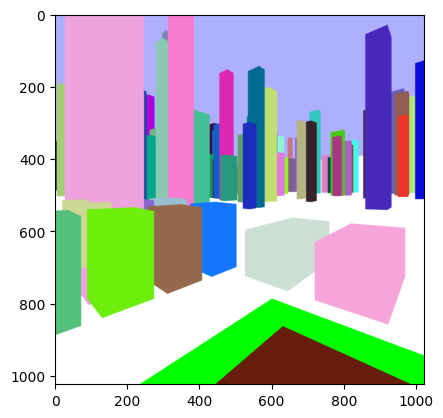

In [61]:
pov = Point(0,20,40)
direction = Point(1,0.9,-0.1)
sc2 = Scene(skretch, pov, direction, resolution = (1024,1024), vision_angle = 40, margin = 1, verbose = verbose)
img = sc2.get_img()


In [46]:
models = {
    "stable": "CompVis/stable-diffusion-v1-4",
    "realistic": "SG161222/Realistic_Vision_V5.1_noVAE",
    "dreamshaper": "Lykon/DreamShaper",
    "deliberate": "XpucT/Deliberate",
    "photon": "digiplay/Photon_v1",
    "meinamix": "stablediffusionapi/meinamix",
    "openjourney": "prompthero/openjourney-v4",
    "dreamlike": "dreamlike-art/dreamlike-photoreal-2.0",
    "xl": "stabilityai/stable-diffusion-xl-base-1.0",
}

promptsub = "Epic Realistic, high Quality, masterpiece, neutral colors, screen space refractions, (intricate details, hyperdetailed:1.2), artstation, complex background"
prompt = "A  city with houses, skyscraper, factories and a park" + promptsub
prompt = "a cyberpunk city, epic realistic, (hdr:1.4), (muted colors:1.4), apocalypse, abandoned, screen space refractions, (intricate details), (intricate details, hyperdetailed:1.2), artstation, vignette, complex background, buildings"
device = "cuda"

model_id_or_path = models['dreamshaper']


In [63]:
prompt = "a cyberpunk city. Neon lighting, Dark skies. Epic realistic, (hdr:1.4), (muted colors:1.4), apocalypse, abandoned, screen space refractions, (intricate details), (intricate details, hyperdetailed:1.4), artstation, vignette"

model_id_or_path = models['realistic']

image = Image.fromarray(img)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-seg", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id_or_path, controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

image = pipe(prompt, image, num_inference_steps=800).images[0]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

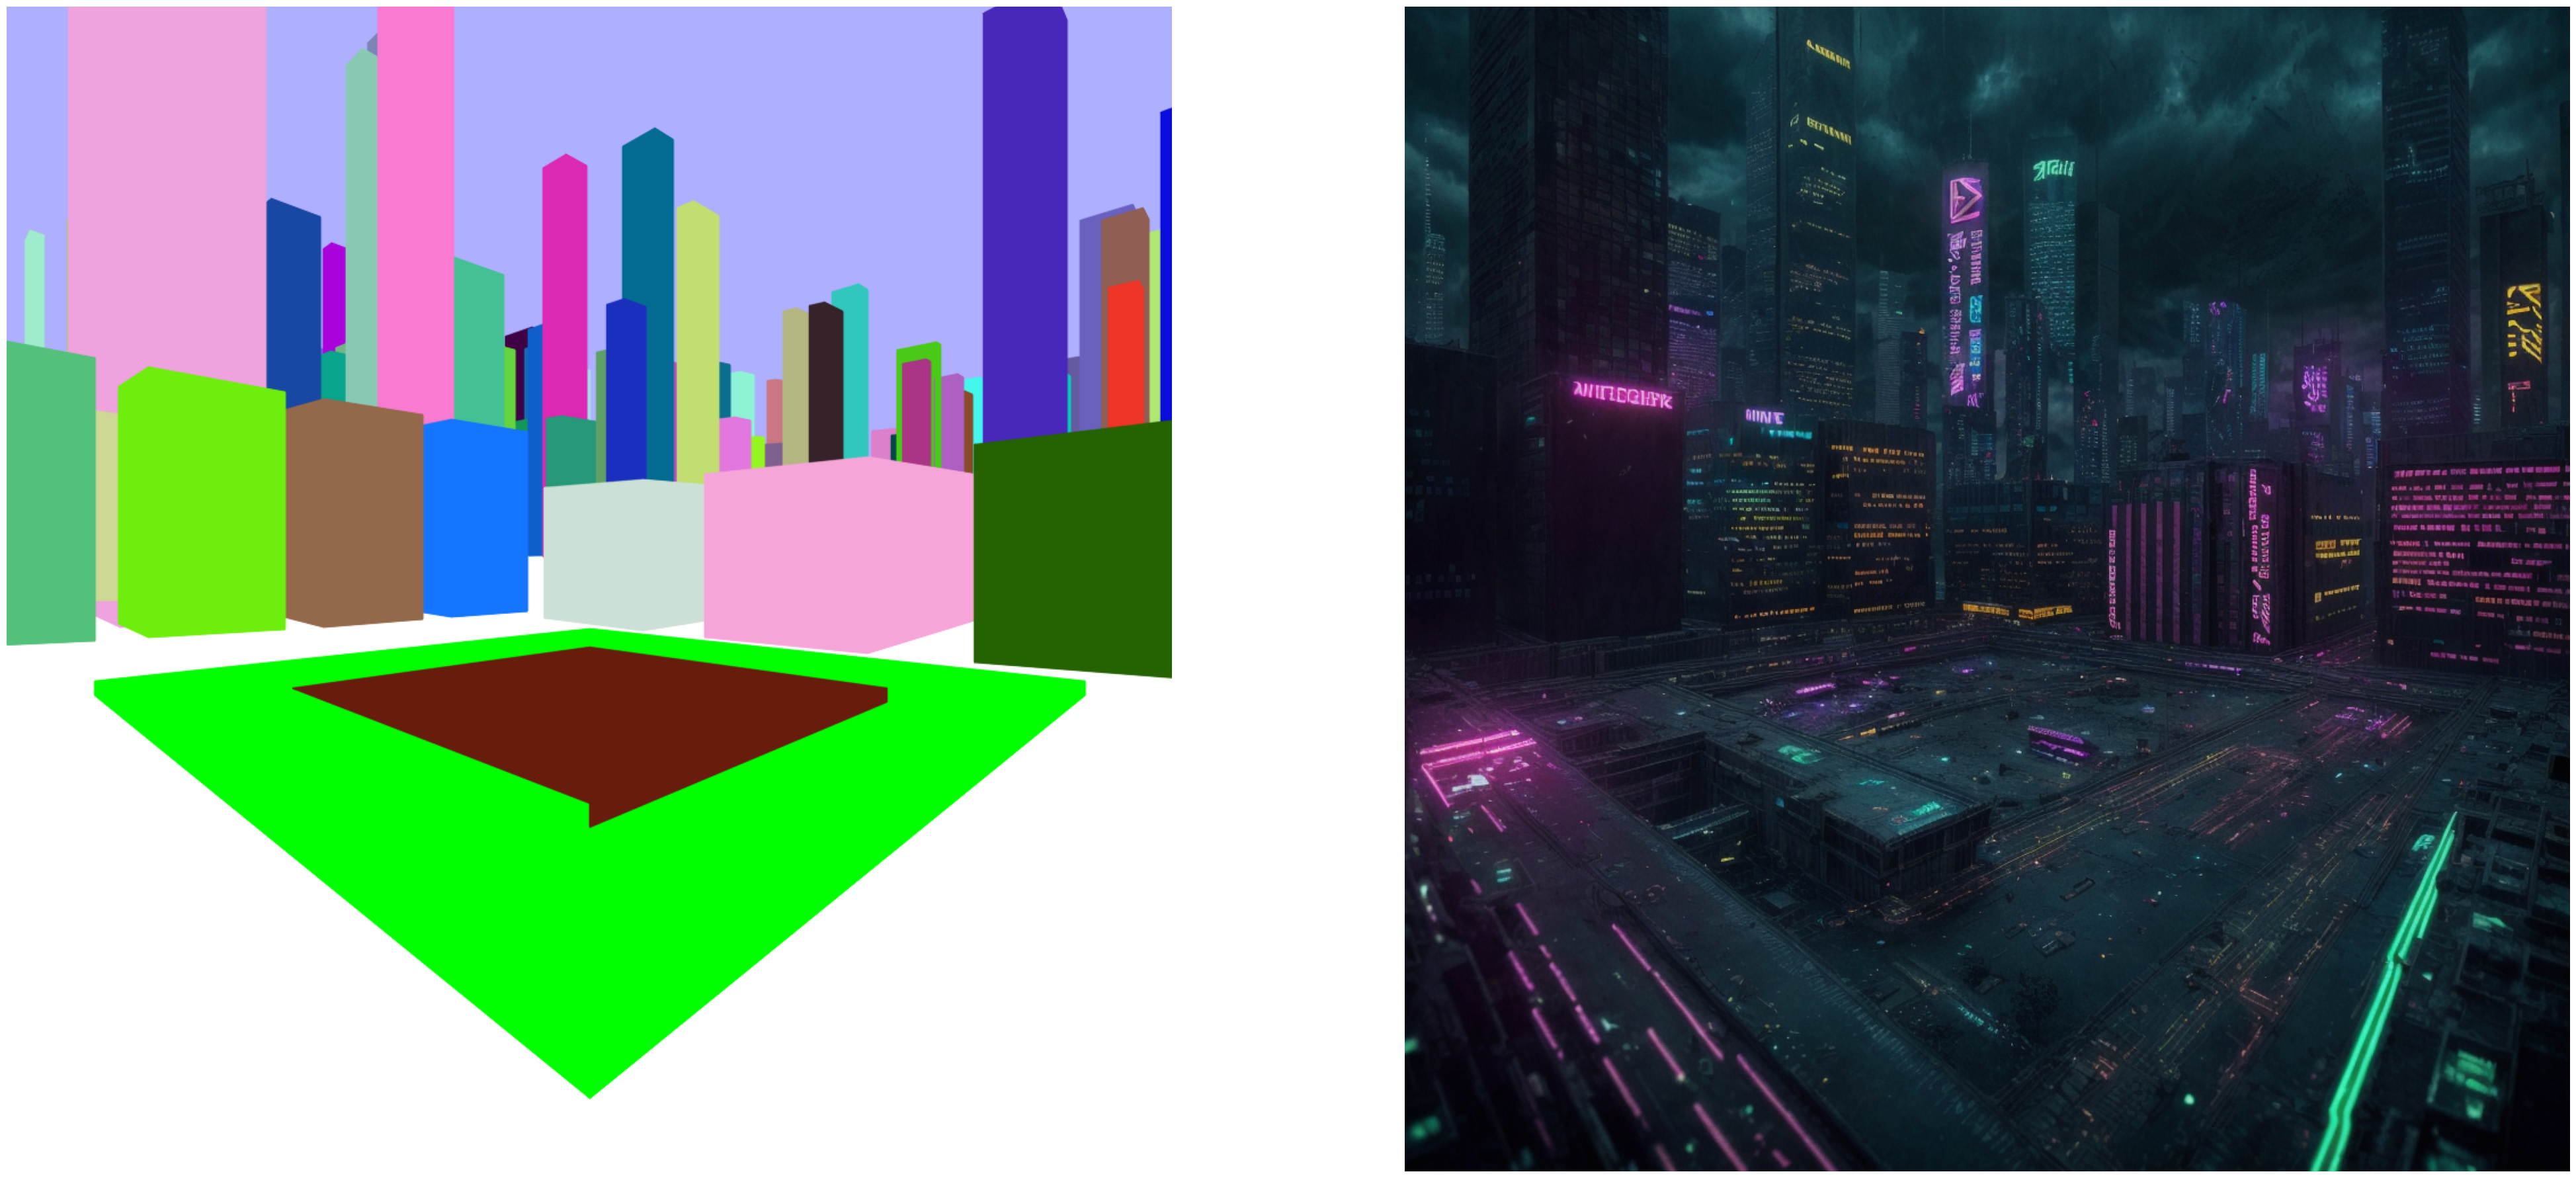

In [64]:
fig, ax= plt.subplots(1,2, figsize=(50, 25))

ax[0].imshow(Image.fromarray(img))
ax[0].grid(False)
ax[0].axis('off')
ax[1].imshow(image)
ax[1].grid(False)
ax[1].axis('off')
plt.show()

PIL.Image.Image

In [408]:
mapping = np.zeros((160,160,3),dtype = np.uint8)
img = np.zeros((160,160,3),dtype = np.uint8)

pp = np.array([(4,8),(20,20),(25,30),(9,18)])*4 + (50,-20)
mapping = cv2.drawContours(mapping, [pp], 0, (200,0,0), -1, cv2.LINE_AA);

    
##  1    2


##  4    3
plt.imshow(mapping)
plt.show()
x = np.arange(img.shape[0])
img[x,:,0] = x*255/(img.shape[0])
y = np.arange(img.shape[1])
y.resize(1, img.shape[1],1)
img[x,:,2] = y*255/(img.shape[1])


plt.imshow(img)
plt.show()


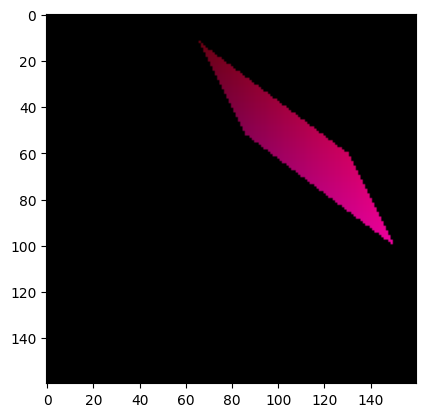

In [409]:
idx1,idx2 = np.where(mapping[:,:,0] == 200)

for i in range(len(idx1)):
    image_copy= np.zeros((160,160,3),dtype = np.uint8)
    image_copy[idx1,idx2,:] = img[idx1,idx2,:]
plt.imshow(image_copy)

In [410]:

v1_2d = pp[1]-pp[0]
v2_2d = pp[3]-pp[0]
origin_x, origin_y  = pp[0]

In [411]:
a,b = (pp[1]-pp[0])
c,d = (pp[3]-pp[0])

## invert [a,b,c,d] to get the inverse mapping

T_xx, T_xy, T_yx, T_yy = [d, -b, -c , a]  /(a*d-b*c)

shape = (10,10)

distortion_x = shape[0]-1
distortion_y= shape[1]-1

T_xx = T_xx * distortion_x
T_yx = T_yx * distortion_x
T_xy = T_xy * distortion_y
T_yy = T_yy * distortion_y

In [412]:
mapping[idx1,idx2,1] = np.round((idx2 - origin_x) * T_xx + (idx1 - origin_y) * T_yx)
mapping[idx1,idx2,2] = np.round((idx2 - origin_x) * T_xy + (idx1 - origin_y) * T_yy)

In [413]:
max((idx2 - origin_x) * T_xx + (idx1 - origin_y) * T_yx)
max( (idx2 - origin_x) * T_xy + (idx1 - origin_y) * T_yy)


9.0

In [414]:
mapping[idx1,idx2,:]

array([[200,   0,   0],
       [200,   0,   0],
       [200,   0,   0],
       ...,
       [200,   9,   9],
       [200,   9,   9],
       [200,   9,   9]], dtype=uint8)

In [415]:

final_image = np.zeros((shape[0],shape[1],3),dtype = np.uint8)
for i in range(len(idx1)):
    ix1 = idx1[i]
    ix2 = idx2[i]
    
    color = img[ix1,ix2,:]
    qid, pos_x, pos_y = mapping[ix1,ix2,:]
    
    final_image[pos_y,pos_x,:] = color
    

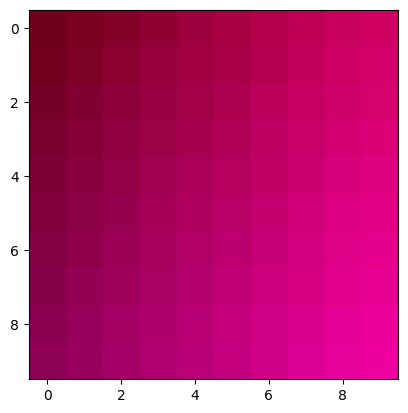

In [416]:
plt.imshow(final_image)


In [366]:
np.clip(7,0,5)

5

In [18]:
from PIL import Image
from transformers import pipeline
import numpy as np
import cv2
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from diffusers.utils import load_image

image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-normal/resolve/main/images/toy.png").convert("RGB")

depth_estimator = pipeline("depth-estimation", model ="Intel/dpt-hybrid-midas" )

image = depth_estimator(image)['predicted_depth'][0]

image = image.numpy()

image_depth = image.copy()
image_depth -= np.min(image_depth)
image_depth /= np.max(image_depth)

# bg_threhold = 0.4

# x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
# x[image_depth < bg_threhold] = 0

# y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
# y[image_depth < bg_threhold] = 0

# z = np.ones_like(x) * np.pi * 2.0

# image = np.stack([x, y, z], axis=2)
# image /= np.sum(image ** 2.0, axis=2, keepdims=True) ** 0.5
# image = (image * 127.5 + 127.5).clip(0, 255).astype(np.uint8)
# image = Image.fromarray(image)

In [25]:
image

array([[   0.      ,    0.      ,    0.      , ...,   41.145554,
          40.81196 ,   35.27891 ],
       [   0.      ,    0.      ,    0.      , ...,   40.86017 ,
          40.50976 ,   42.35265 ],
       [   0.      ,    0.      ,    0.      , ...,   40.87688 ,
          40.43918 ,   40.88838 ],
       ...,
       [2299.1582  , 2304.202   , 2303.467   , ..., 2270.22    ,
        2263.7551  , 2262.3872  ],
       [2321.88    , 2322.02    , 2322.8933  , ..., 2281.5906  ,
        2284.9534  , 2275.0652  ],
       [2321.7178  , 2332.6348  , 2327.2822  , ..., 2301.9663  ,
        2302.252   , 2298.837   ]], dtype=float32)

In [20]:
cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)

array([[  0.       ,   0.       ,   0.       , ...,  -0.6933975,
         -8.748322 ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,  -0.6352043,
         -2.870182 ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   1.1464691,
          2.067791 ,   0.       ],
       ...,
       [  0.       ,  10.812256 ,  -6.8771973, ..., -30.11206  ,
        -22.532715 ,   0.       ],
       [  0.       ,  11.9001465,   6.5273438, ..., -32.025635 ,
        -24.01294  ,   0.       ],
       [  0.       ,  13.155762 ,  12.166016 , ..., -34.81494  ,
        -19.30957  ,   0.       ]], dtype=float32)

In [44]:
I = np.zeros((7,7,3))


np.expand_dims(((I == 1).sum(2) != 3),2).shape

(7, 7, 1)

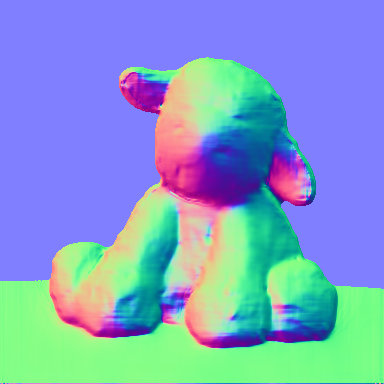

In [9]:
image

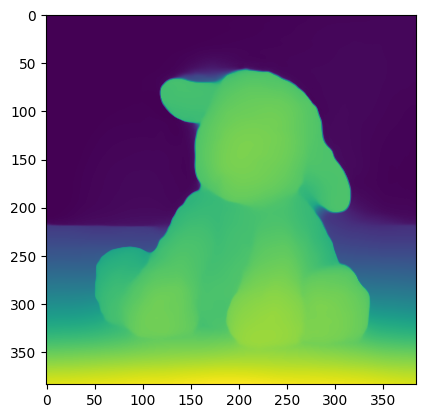

In [6]:
plt.imshow(image_depth)